<h1 style="text-align:center;">Enhancing Brain Tumor Diagnosis with MRI and Neural Networks</h1>

## Introduction

A brain tumor is an abnormal growth of cells within the brain or the central spinal canal. These tumors can be either benign (non-cancerous) or malignant (cancerous), and they can originate in the brain itself (primary brain tumors) or spread from other parts of the body. Common types of brain tumors include gliomas, meningiomas, and pituitary tumors, each varying in behavior, growth rate, and response to treatment.

The timely and accurate detection of brain tumors is crucial for effective treatment and improved patient outcomes. This notebook aims to demonstrate the application of advanced deep learning techniques to enhance the diagnosis of brain tumors using MRI scans. By leveraging neural networks, we strive to provide a reliable and efficient tool for the medical community that can assist in the early detection and precise localization of tumors.

For hospitals and doctors, this approach promises several significant benefits. Enhanced diagnostic accuracy reduces the likelihood of missed diagnoses and improves the accuracy of tumor detection. Increased efficiency automates the analysis process, allowing radiologists and doctors to focus more on patient care rather than time-consuming image reviews. Early intervention facilitated by this technology enables earlier detection of tumors, leading to timely and targeted treatment interventions which can significantly improve patient outcomes. Furthermore, resource optimization frees up valuable medical resources by streamlining the diagnostic workflow.

In [2]:
#import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation, RandomContrast, RandomZoom, RandomFlip, RandomTranslation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [3]:
# General plot parameters
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams.update({'font.size': 15})

In [4]:
# Paths and labels
path_train = r"C:\Users\crloc\OneDrive\Documents\SpringBoard\GitHub\SpringBoard\Notebooks\Final Capstone\Complied MRI Images\Training"
path_test = r"C:\Users\crloc\OneDrive\Documents\SpringBoard\GitHub\SpringBoard\Notebooks\Final Capstone\Complied MRI Images\Testing"
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 168

In [5]:
# Count number of images per class
def count_images(directory):
    return {dir: len(os.listdir(os.path.join(directory, dir))) for dir in os.listdir(directory)}

number_of_images_train = count_images(path_train)
number_of_images_test = count_images(path_test)

print("Training examples: ", number_of_images_train.items())
print("Testing examples: ", number_of_images_test.items())

Training examples:  dict_items([('glioma', 1321), ('meningioma', 1339), ('notumor', 1595), ('pituitary', 1457)])
Testing examples:  dict_items([('glioma', 300), ('meningioma', 306), ('notumor', 405), ('pituitary', 300)])


In [6]:
# Function to load images from directory
def load_images_from_directory(directory, labels, image_size):
    X_data = []
    Y_data = []
    for label in labels:
        folderPath = os.path.join(directory, label)
        for filename in os.listdir(folderPath):
            img = cv2.imread(os.path.join(folderPath, filename))
            img = cv2.resize(img, (image_size, image_size))
            X_data.append(img)
            Y_data.append(label)
    return X_data, Y_data

# Load training and testing data
number_of_images_train = count_images(path_train)
number_of_images_test = count_images(path_test)
print("Training examples: ", number_of_images_train.items())
print("Testing examples: ", number_of_images_test.items())

X_data_train, Y_data_train = load_images_from_directory(path_train, labels, image_size)
X_data_test, Y_data_test = load_images_from_directory(path_test, labels, image_size)

# Combine train and test data for EDA purposes
X_data = X_data_train + X_data_test
Y_data = Y_data_train + Y_data_test

Training examples:  dict_items([('glioma', 1321), ('meningioma', 1339), ('notumor', 1595), ('pituitary', 1457)])
Testing examples:  dict_items([('glioma', 300), ('meningioma', 306), ('notumor', 405), ('pituitary', 300)])


The dataset for this brain tumor detection project consists of MRI images categorized into four distinct classes: glioma, meningioma, no tumor, and pituitary tumor. The dataset is divided into training and testing sets to facilitate model development and evaluation.

Now that we have loaded in our data we will explore some of the data.

## Exploratory Data Analysis

Overall mean pixel value: 47.55
Overall standard deviation of pixel values: 46.98


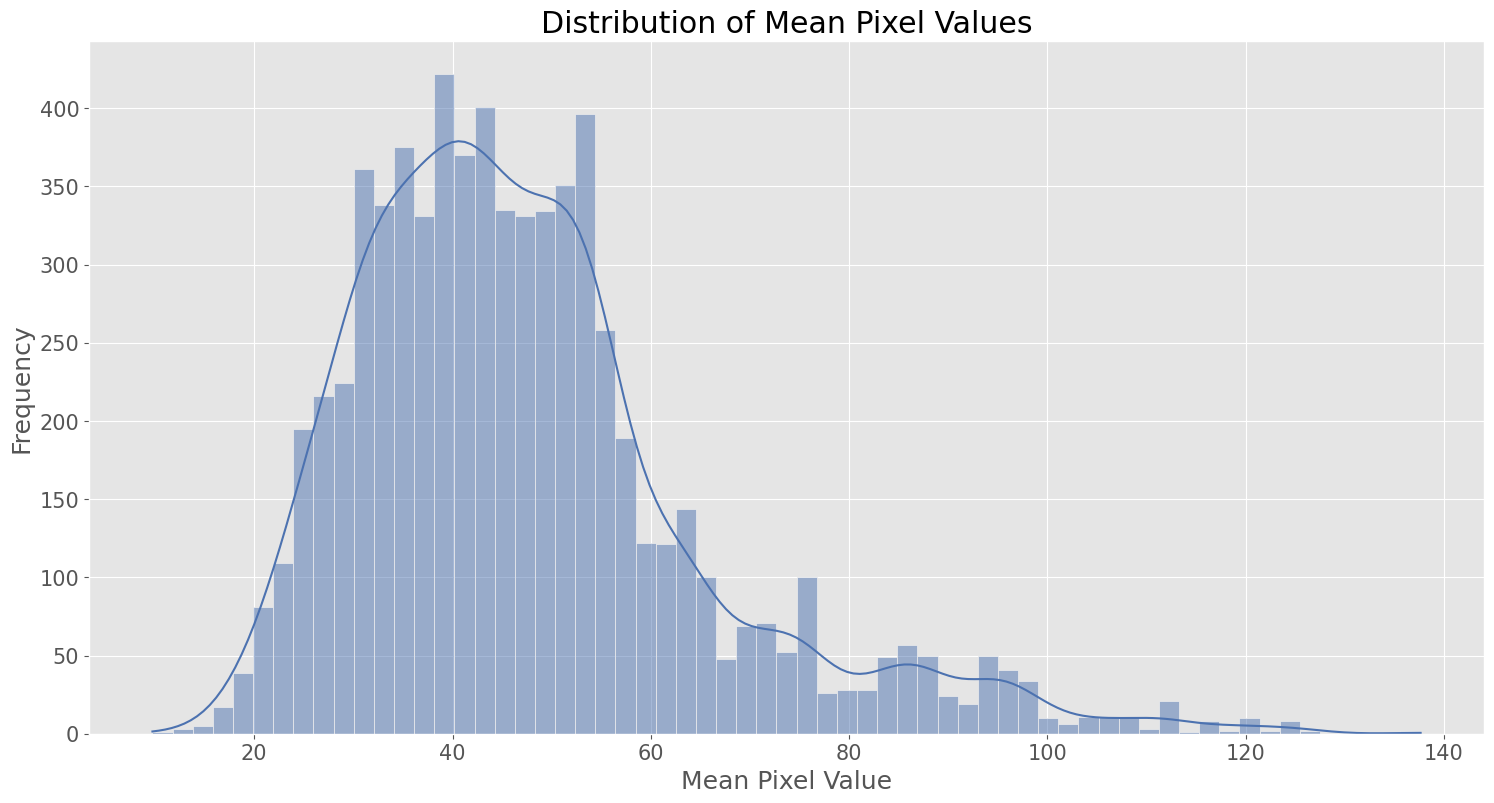

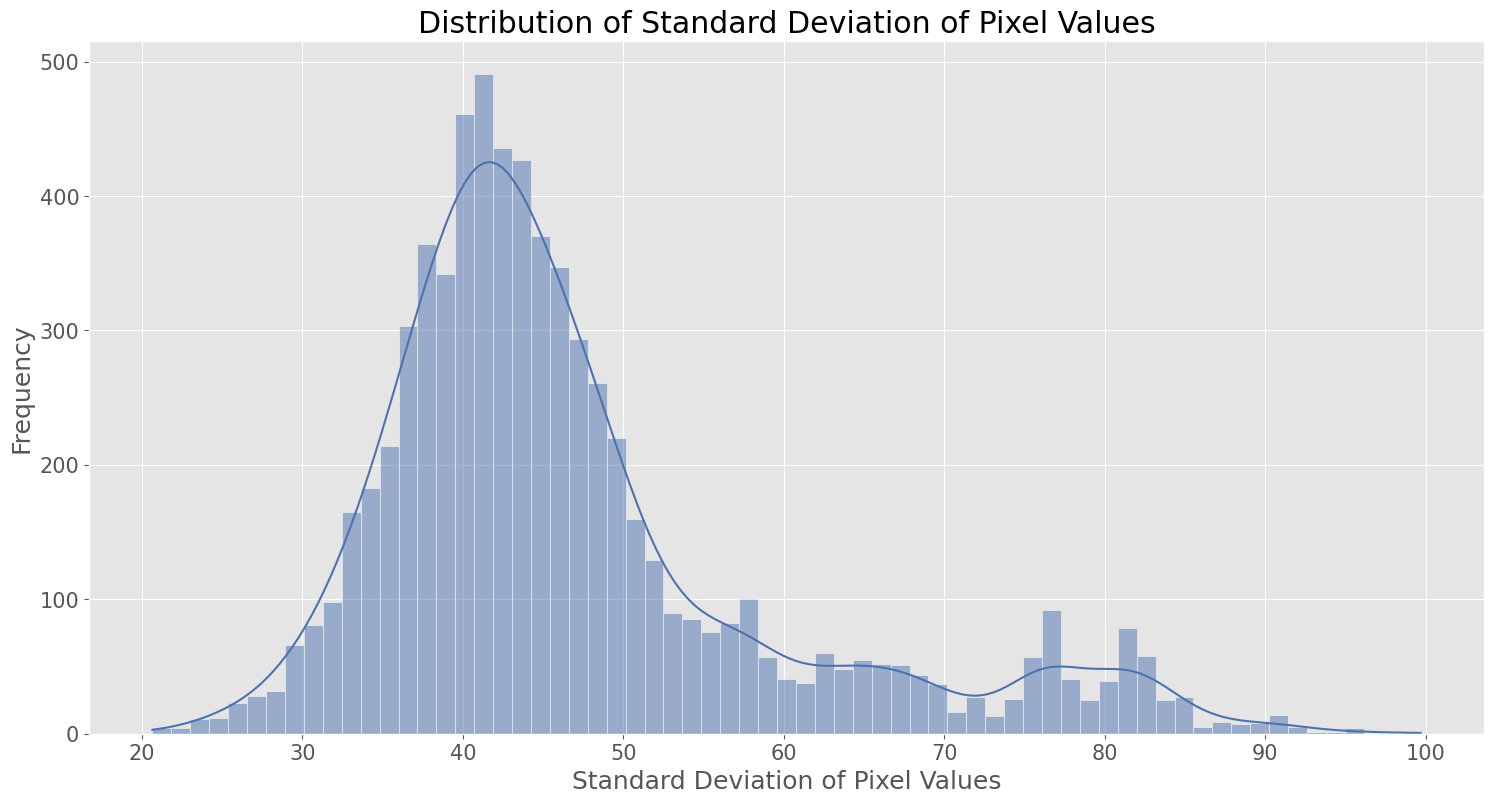

In [7]:
# EDA functions
def analyze_images(X_data):
    X_data_np = np.array(X_data)
    means = X_data_np.mean(axis=(1, 2, 3))
    stds = X_data_np.std(axis=(1, 2, 3))
    
    print(f"Overall mean pixel value: {means.mean():.2f}")
    print(f"Overall standard deviation of pixel values: {stds.mean():.2f}")
    
    # Histogram for mean pixel values
    sns.histplot(means, kde=True, color='#4C72B0')
    plt.title('Distribution of Mean Pixel Values')
    plt.xlabel('Mean Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Histogram for standard deviation of pixel values
    sns.histplot(stds, kde=True, color='#4C72B0')
    plt.title('Distribution of Standard Deviation of Pixel Values')
    plt.xlabel('Standard Deviation of Pixel Values')
    plt.ylabel('Frequency')
    plt.show()

analyze_images(X_data)

The histograms above illustrate the distribution of mean pixel values and the standard deviation of pixel values across the MRI images in the dataset. The mean pixel value distribution shows a right-skewed shape, with most images having mean pixel values between 20 and 60, and a calculated overall mean of 47.55. This indicates that the majority of the images have relatively low average pixel intensities, likely due to the inherent dark background in MRI scans. 

The distribution of the standard deviation of pixel values, which has an overall mean of 46.98, is also somewhat right-skewed, with most images having standard deviations between 30 and 60. This suggests a moderate level of variation in pixel intensities within the images, reflective of the varied tissue densities and structures within brain MRI scans. 

These distributions imply that the images are generally consistent in their intensity profiles, which is beneficial for training robust deep learning models for tumor detection and classification. The observed skewness towards lower mean pixel values and moderate standard deviations further emphasizes the need for effective normalization and preprocessing steps to enhance model performance.

In [8]:
#Image shape
image_shapes = [img.shape for img in X_data]
unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")

Unique image shapes: {(168, 168, 3)}


The analysis of image shapes within the dataset indicates that all images have a consistent shape of (168, 168, 3), meaning each image is 168 pixels in width, 168 pixels in height, and has three color channels (RGB). This uniformity in image dimensions is crucial for training deep learning models, as neural networks require inputs of the same shape to process the data effectively. 

In [9]:
#detect blurred images
def detect_blur(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

blurred_images = [img for img in X_data if detect_blur(img)]
print(f"Number of blurred images: {len(blurred_images)}")

Number of blurred images: 5


In [10]:
#Remove blurred images
X_data_cleaned = [img for img in X_data if not detect_blur(img)]
Y_data_cleaned = [label for img, label in zip(X_data, Y_data) if not detect_blur(img)]

print(f"Number of images after removing blurred ones: {len(X_data_cleaned)}")

Number of images after removing blurred ones: 7018


The analysis of image quality within the dataset revealed that out of the total images, only 5 were identified as blurred using a Laplacian variance threshold of 100, indicating that the vast majority of images are clear and suitable for training. After removing these blurred images, the dataset now consists of 7,018 images, ensuring high-quality data for model training. This minimal number of blurred images suggests that the dataset is well-prepared and robust, reducing the risk of poor model performance due to low-quality inputs. 

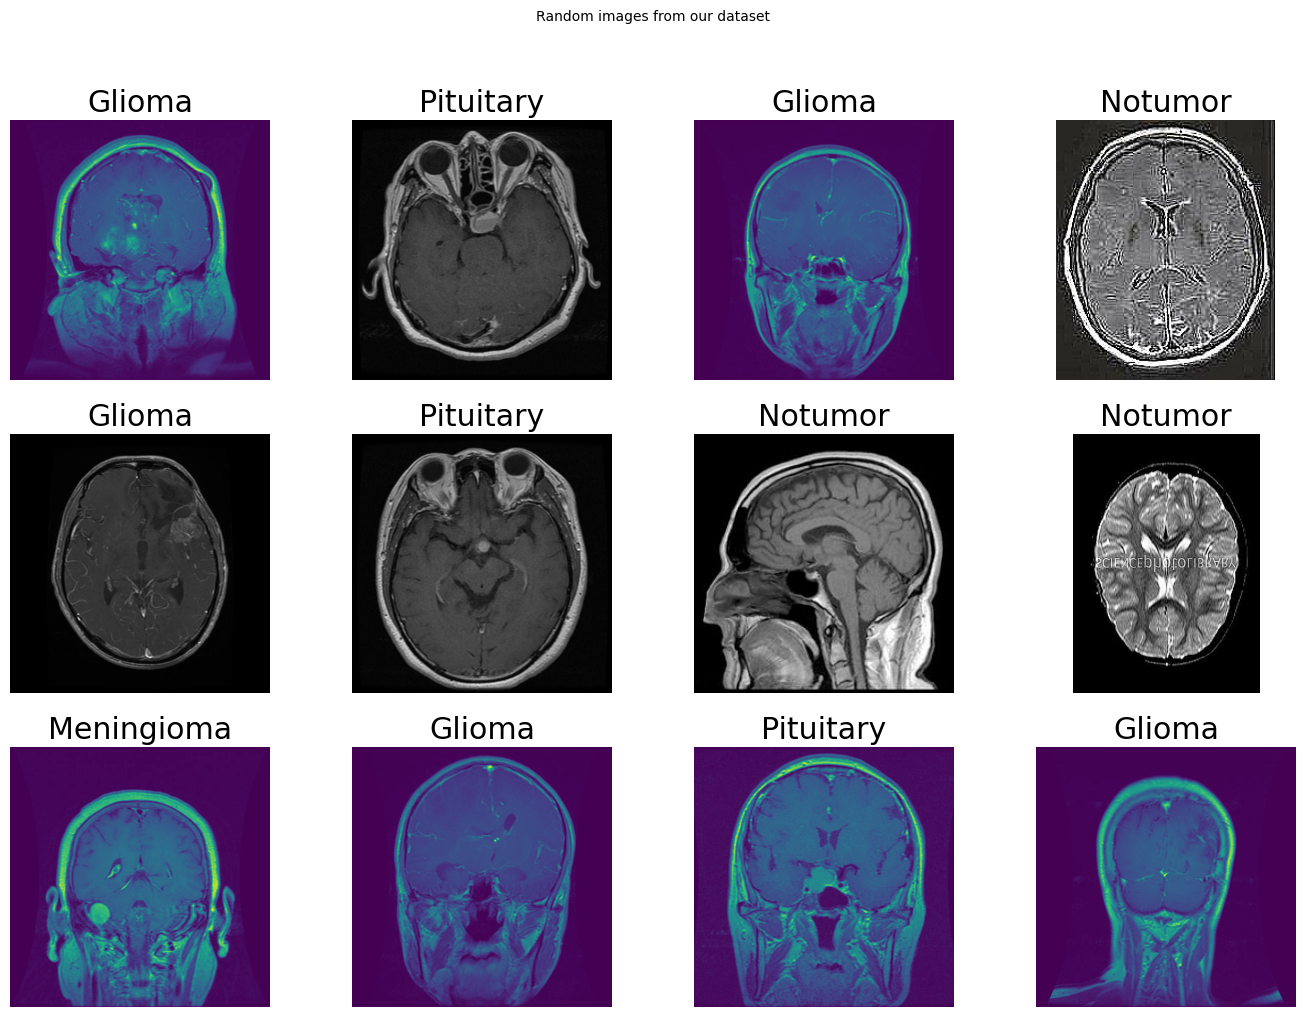

In [11]:
# Visualize random images from the dataset
def visualize_random_images(paths, num_images=12):
    all_image_files = []
    for path in paths:
        image_files = os.listdir(path)
        full_paths = [os.path.join(path, img_file) for img_file in image_files]
        all_image_files.extend(full_paths)
    
    random_images = random.sample(all_image_files, num_images)
    
    plt.figure(figsize=(14, 10))
    plt.suptitle('Random images from our dataset', fontsize=10, y=1.02)
    
    for i, image_file in enumerate(random_images):
        img = mpimg.imread(image_file)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(os.path.dirname(image_file)).capitalize())
    
    plt.tight_layout()
    plt.show()

# Define paths for each label
paths = [os.path.join(path_train, label) for label in labels]
visualize_random_images(paths, num_images=12)

The visualization of random images from the dataset provides a comprehensive overview of the diverse MRI scans available, showcasing different classes such as glioma, meningioma, no tumor, and pituitary tumor. Each image is clearly labeled, indicating its classification and providing insight into the various anatomical views and sections of the brain, including axial, coronal, and sagittal perspectives. This diversity in image types is crucial for training a robust deep learning model that can generalize well across different MRI scans, ensuring it can accurately identify and classify brain tumors regardless of the specific scan type or angle.

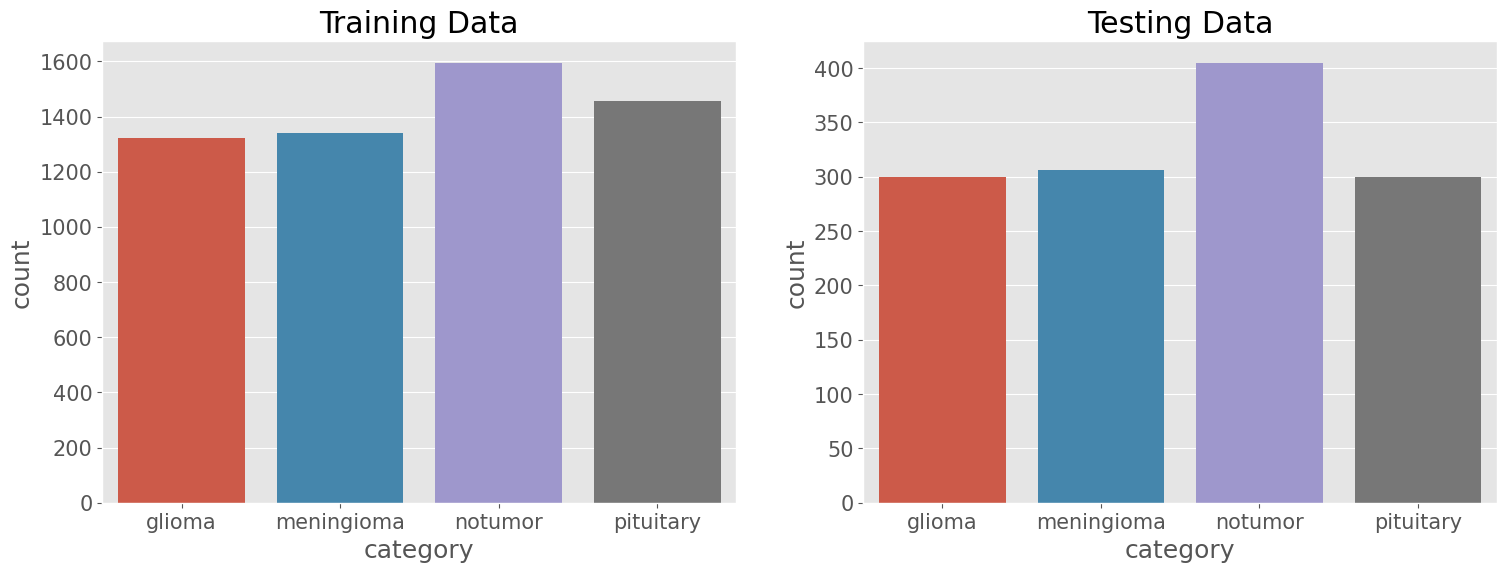

In [12]:
# Bar graph of image counts
def plot_image_counts(train_counts, test_counts):
    train_df = pd.DataFrame.from_dict(train_counts, orient='index', columns=['count']).reset_index()
    train_df = train_df.rename(columns={'index': 'category'})
    test_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['count']).reset_index()
    test_df = test_df.rename(columns={'index': 'category'})
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    sns.barplot(x='category', y='count', data=train_df, ax=axes[0])
    axes[0].set_title('Training Data')
    
    sns.barplot(x='category', y='count', data=test_df, ax=axes[1])
    axes[1].set_title('Testing Data')
    
    plt.show()

plot_image_counts(number_of_images_train, number_of_images_test)


The bar graphs illustrate the distribution of image counts across different categories for both the training and testing datasets. We see a consistent distribution between training and testing sets which will ensure that the model will be trained and evaluated on a balanced dataset, reflecting real-world scenarios and promoting better generalization.

We have thoroughly examined various aspects of our dataset. The high-quality images, balanced class distribution, and diverse perspectives in the MRI scans provide a solid foundation for building a reliable and effective model for brain tumor detection and classification. With the dataset's integrity ensured, we can confidently proceed to the next stages of model training and evaluation.

# Preprocessing

In [13]:
#Normalization
X_data = np.array(X_data) / 255.0

In [14]:
#Encoding Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_data_encoded = label_encoder.fit_transform(Y_data)

In [15]:
#Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data_encoded, test_size=0.2, random_state=42)

In [16]:
#Data Augmentation
data_augmentation = keras.Sequential([
    RandomRotation(0.1),
    RandomContrast(0.1),
    RandomZoom(0.1),
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1)
])

In the preprocessing phase, we normalized the pixel values of our MRI images to a range of 0 to 1, ensuring consistency across all images. We encoded the categorical tumor labels into numerical form using LabelEncoder. We then split the dataset into training and testing sets with an 80-20 ratio using train_test_split. To enhance our dataset, we applied data augmentation techniques such as random rotation, contrast adjustment, zooming, horizontal flipping, and translation. These steps help improve the model's robustness and accuracy.

## Modeling

In this section, we will develop a convolutional neural network (CNN) to identify and classify brain tumors from MRI images. We will start with a simple CNN architecture and gradually enhance it by adding more layers, batch normalization, and other advanced techniques. 

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 141s 228ms/step - accuracy: 0.5312 - loss: 1.0569 - val_accuracy: 0.7452 - val_loss: 0.5875
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.8008 - loss: 0.5018 - val_accuracy: 0.8448 - val_loss: 0.3896
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.8502 - loss: 0.3671 - val_accuracy: 0.8833 - val_loss: 0.3165
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.8687 - loss: 0.3451 - val_accuracy: 0.8520 - val_loss: 0.3389
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.9169 - loss: 0.2359 - val_accuracy: 0.8982 - val_loss: 0.2607
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.9154 - loss: 0.2216 - val_accuracy: 0.9203 - val_loss: 0.2218
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.9374 - loss: 0.1717 - val_accuracy: 0.9281 - val_loss: 0.2095
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9405 - loss: 0.1537 

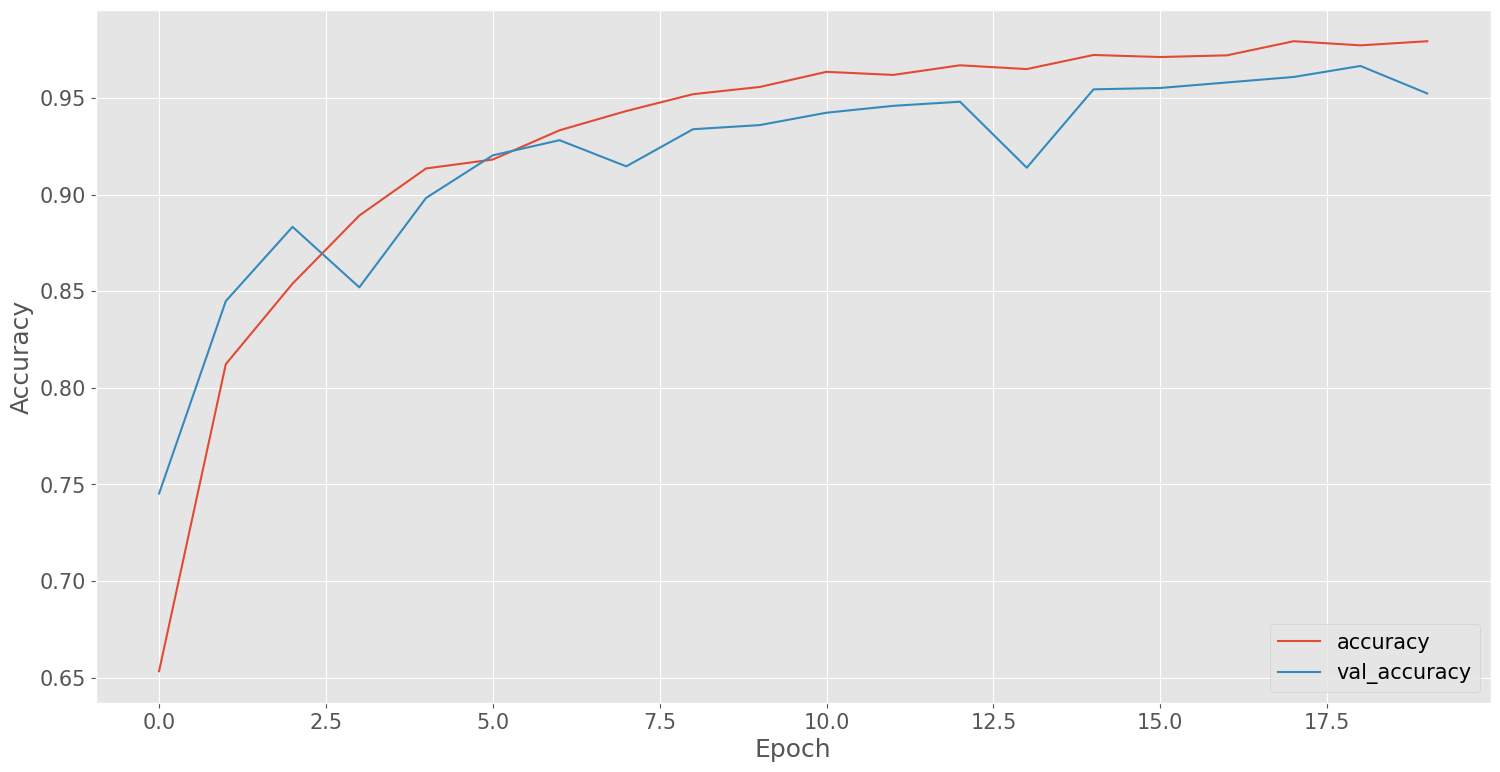

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Updated CNN model with an additional layer
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(168, 168, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Additional convolutional and pooling layers
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Our convolutional neural network (CNN) model demonstrated impressive performance in detecting and classifying brain tumors from MRI images. After training the model for 20 epochs, it achieved a training accuracy of 98.00% and a validation accuracy of 95.23%, indicating strong learning and generalization capabilities. The model's loss values also decreased significantly over the epochs, showcasing effective learning and minimal overfitting. Upon evaluation on the test set, the model achieved a test accuracy of 96.50%, confirming its reliability in predicting unseen data.

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


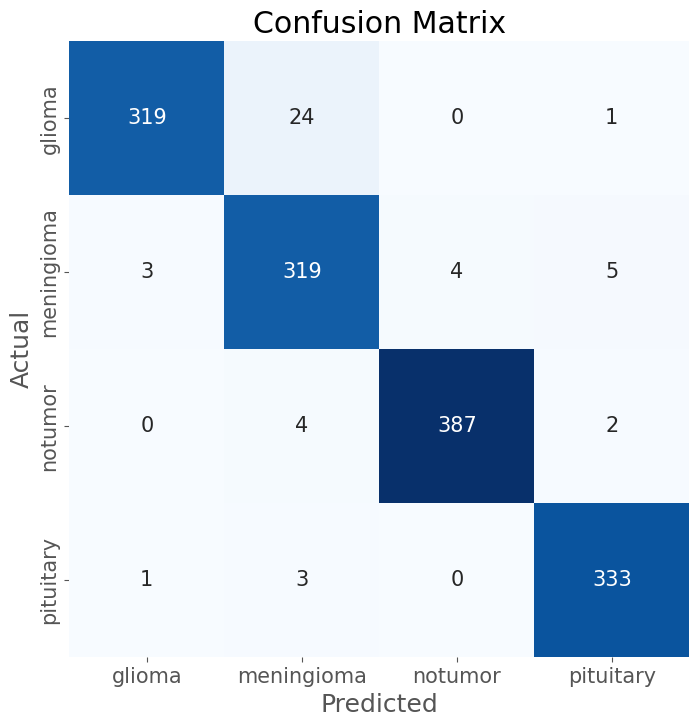

In [20]:
# Import necessary library
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix with improved readability
fig, ax = plt.subplots(figsize=(8, 8))  # Reduced figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix further illustrated the model's performance across different tumor classes, highlighting high accuracy in identifying glioma, notumor, and pituitary tumor classes, with some misclassifications observed in the meningioma class. Overall, this model represents a robust tool for assisting medical professionals in early and accurate brain tumor diagnosis, ultimately enhancing patient care and treatment outcomes.

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.6598 - loss: 0.9341 - val_accuracy: 0.8278 - val_loss: 0.4435
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 206s 580ms/step - accuracy: 0.8339 - loss: 0.4473 - val_accuracy: 0.8719 - val_loss: 0.3232
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 200s 565ms/step - accuracy: 0.8532 - loss: 0.3866 - val_accuracy: 0.8982 - val_loss: 0.2758
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 563ms/step - accuracy: 0.8612 - loss: 0.3815 - val_accuracy: 0.8890 - val_loss: 0.2746
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 563ms/step - accuracy: 0.8770 - loss: 0.3359 - val_accuracy: 0.8847 - val_loss: 0.2842
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 569ms/step - accuracy: 0.8865 - loss: 0.3070 - val_accuracy: 0.8975 - val_loss: 0.2502
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 198s 561ms/step - accuracy: 0.8981 - loss: 0.2718 - val_accuracy: 0.9060 - val_loss: 0.2420
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 571ms/step - accuracy: 0.8944 - lo

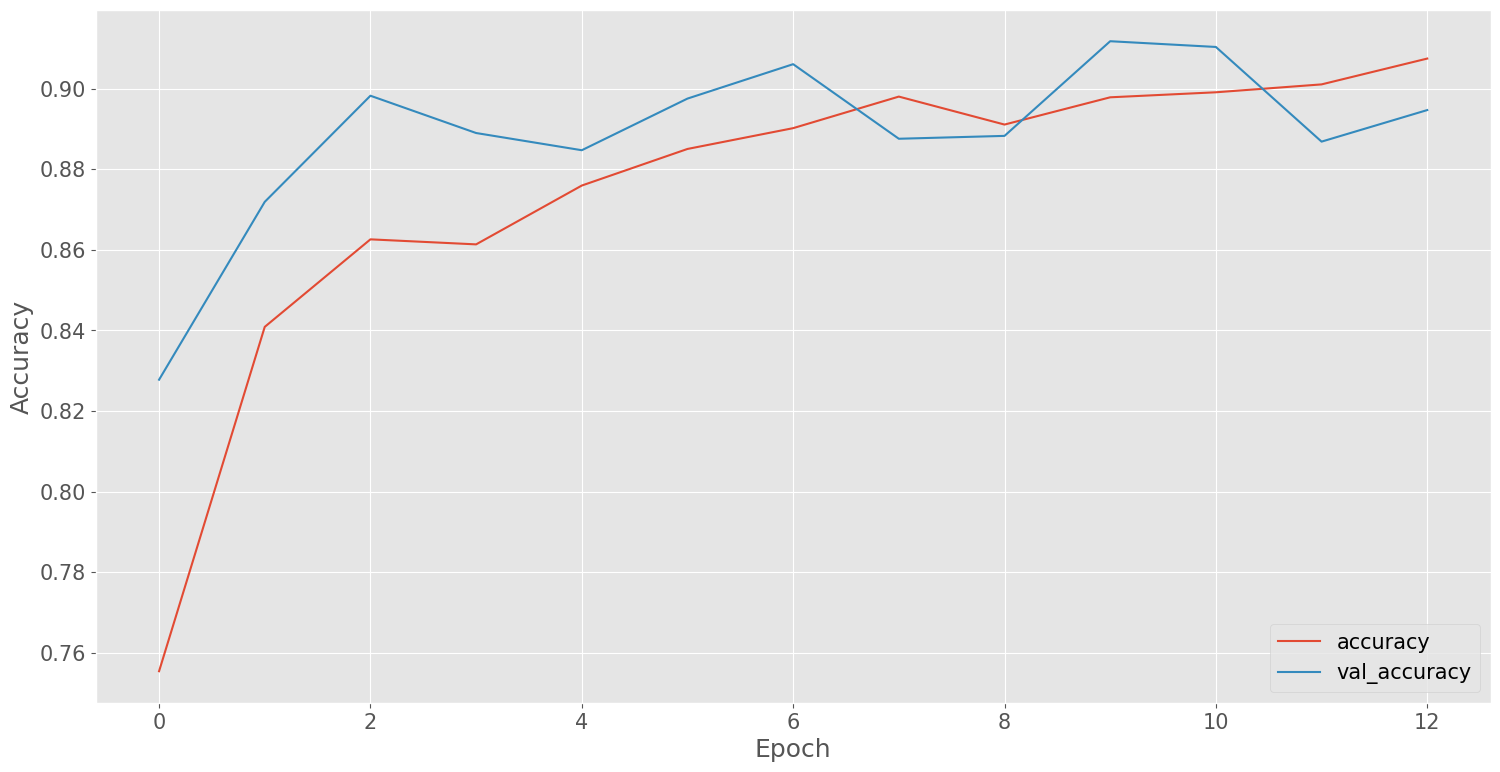

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# Load the DenseNet121 model pre-trained on ImageNet, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(168, 168, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (optional, for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16),
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Our DenseNet121 model, fine-tuned on the MRI dataset, demonstrated strong performance in detecting and classifying brain tumors. After training for 13 epochs, the model achieved a training accuracy of 90.43% and a validation accuracy of 89.47%. The training process was monitored using early stopping to prevent overfitting, and the final test accuracy was 90.75%.

In comparison, our previous CNN model, which consisted of multiple convolutional layers, achieved higher performance metrics. The CNN model reached a training accuracy of 98.00%, a validation accuracy of 95.23%, and an impressive test accuracy of 96.50%.

44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 989ms/step


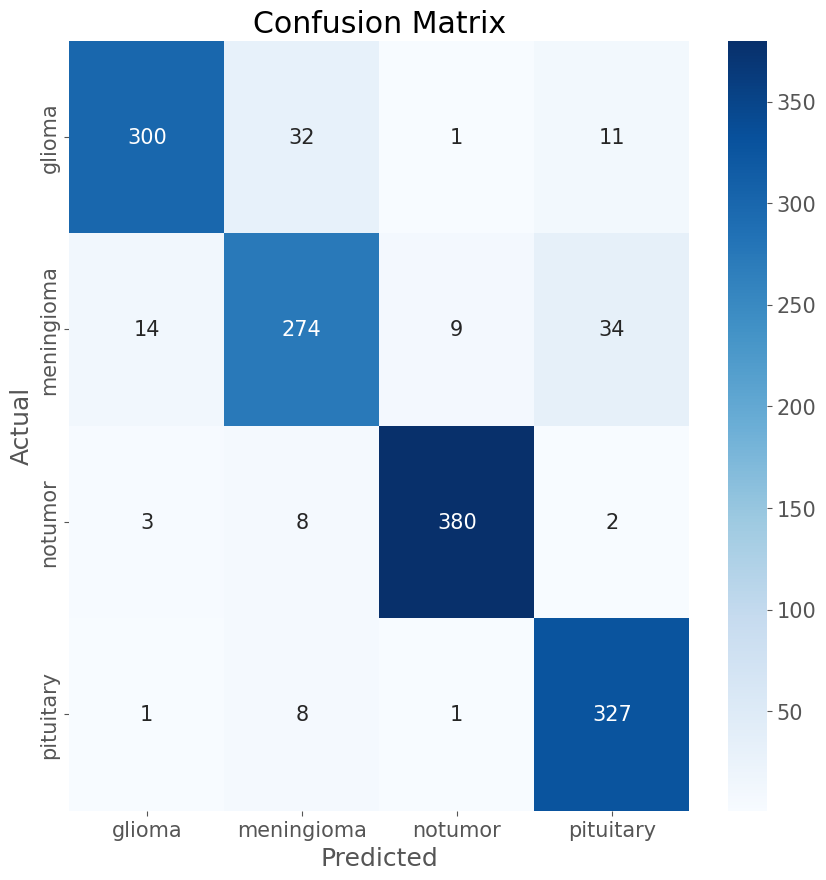

In [23]:
# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Overall, the DenseNet121 model showed high accuracy across all categories, particularly in distinguishing no tumor and pituitary tumors. However, there is a noticeable number of misclassifications between glioma and meningioma, indicating areas for potential improvement. These results highlight the model's effectiveness and suggest that further refinements could enhance its performance in distinguishing between closely related tumor types.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 340s 656ms/step - accuracy: 0.7129 - loss: 0.7657 - val_accuracy: 0.8071 - val_loss: 0.4836
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 91s 240ms/step - accuracy: 0.8551 - loss: 0.3963 - val_accuracy: 0.8797 - val_loss: 0.3374
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - accuracy: 0.8596 - loss: 0.3741 - val_accuracy: 0.8598 - val_loss: 0.4025
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 232ms/step - accuracy: 0.8680 - loss: 0.3216 - val_accuracy: 0.8185 - val_loss: 0.4704
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.8768 - loss: 0.3201 - val_accuracy: 0.8769 - val_loss: 0.3492
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.8835 - loss: 0.3191
Test accuracy: 0.88


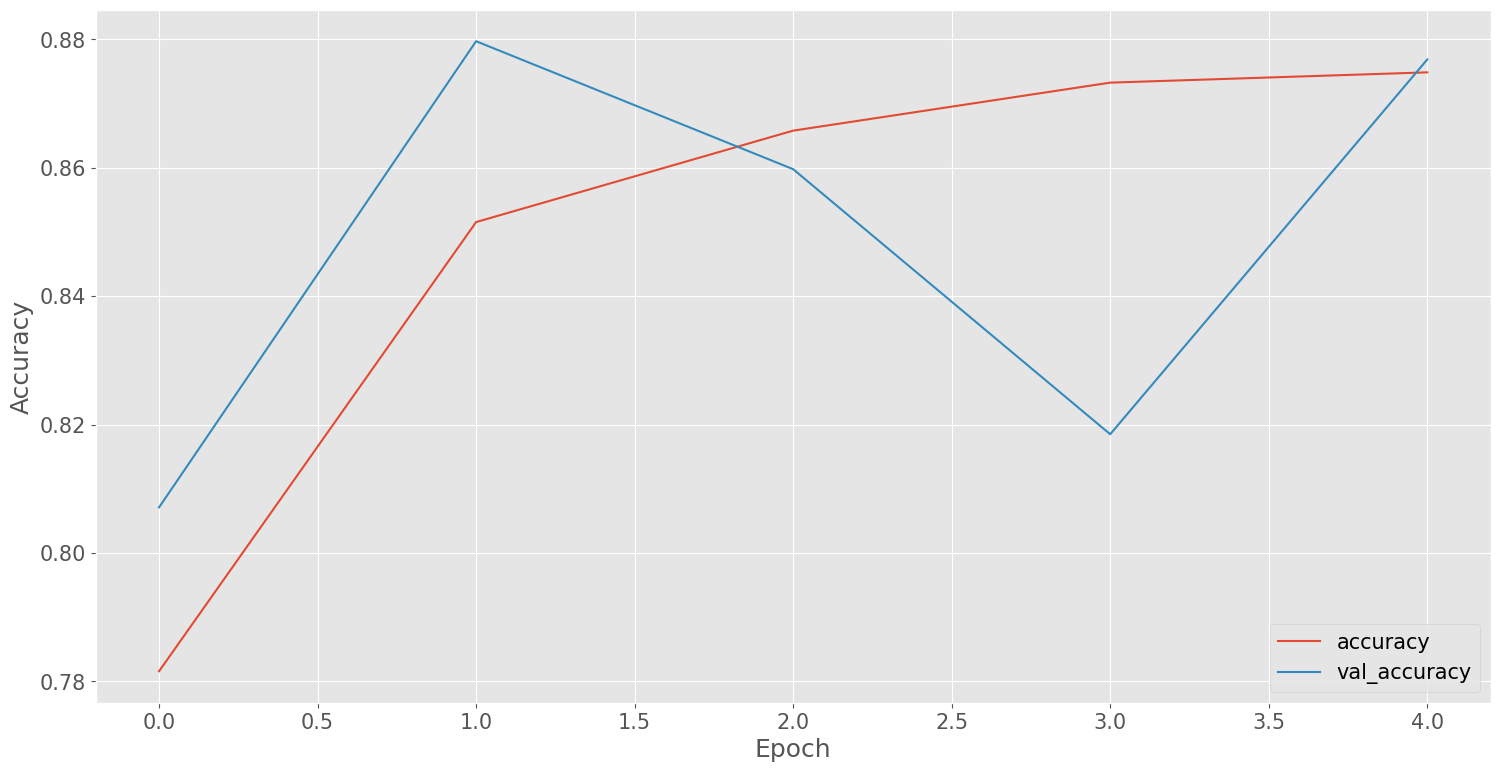

In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(168, 168, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16),
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The MobileNetV2 model was evaluated for its performance in detecting and classifying brain tumors from MRI images. The model was trained over 20 epochs, leveraging data augmentation techniques to enhance the training dataset's diversity and improve generalization.

The MobileNetV2 model achieved a peak training accuracy of 87.68% and a validation accuracy of 87.69%. Upon evaluating the model on the test set, it achieved an accuracy of 88.35%, confirming its reliability and effectiveness in predicting unseen data.

44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 410ms/step


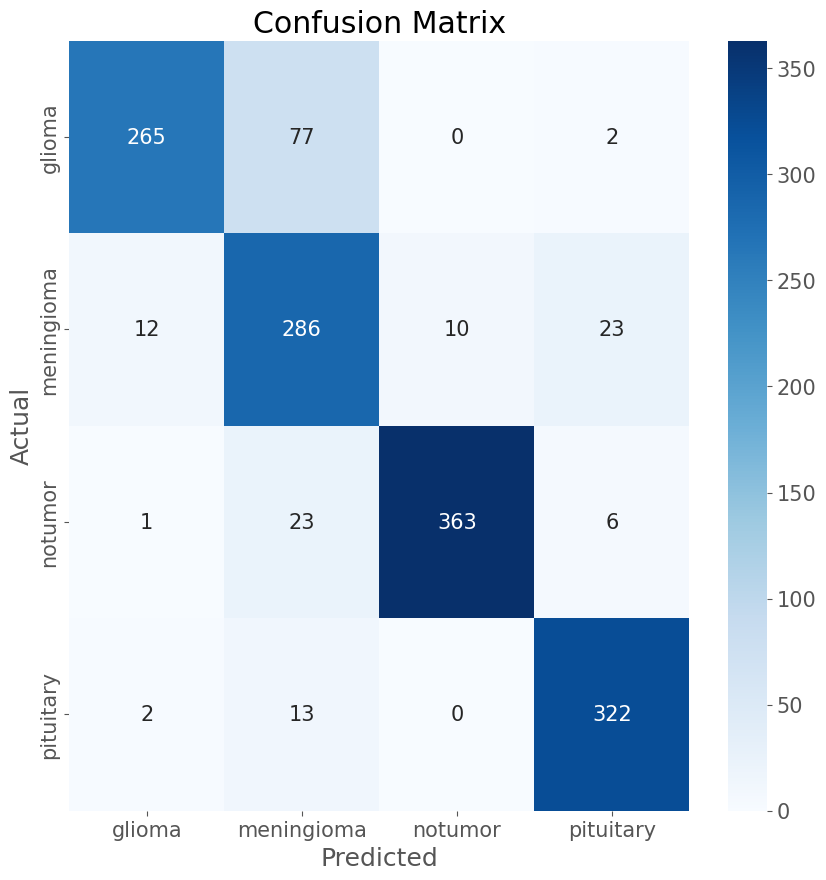

In [26]:
# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

These results from the confsusion matrix highlight the MobileNetV2 model's efficiency in real-time applications while maintaining a good balance between speed and accuracy. Although there are areas for further improvement, especially in differentiating between glioma and meningioma, the model shows robust performance in identifying and classifying brain tumors.

When compared to the CNN and DenseNet models, MobileNetV2 demonstrated faster training times while maintaining competitive accuracy. The CNN model achieved a test accuracy of 96.50%, and DenseNet achieved a test accuracy of 91.75%, both surpassing the MobileNetV2's 88.35%. However, the MobileNetV2's streamlined architecture allowed for quicker iterations, making it a viable option for applications where computational efficiency is paramount. Despite its lower accuracy compared to the CNN model, MobileNetV2 still performed reliably across different tumor categories and demonstrated a commendable ability to generalize from the training data. This trade-off between speed and accuracy makes MobileNetV2 a practical choice for scenarios requiring rapid model deployment and real-time inference.

## Final Model Evaluation

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 300s 464ms/step - accuracy: 0.5508 - loss: 1.0171 - val_accuracy: 0.7153 - val_loss: 0.5977
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.7965 - loss: 0.5199 - val_accuracy: 0.7644 - val_loss: 0.5221
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.8270 - loss: 0.4302 - val_accuracy: 0.8299 - val_loss: 0.3678
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.8724 - loss: 0.3207 - val_accuracy: 0.8890 - val_loss: 0.2811
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.8937 - loss: 0.2644 - val_accuracy: 0.8477 - val_loss: 0.3642
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.9064 - loss: 0.2371 - val_accuracy: 0.9082 - val_loss: 0.2373
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.9228 - loss: 0.2039 - val_accuracy: 0.9139 - val_loss: 0.2373
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.9315 - loss: 0.1758

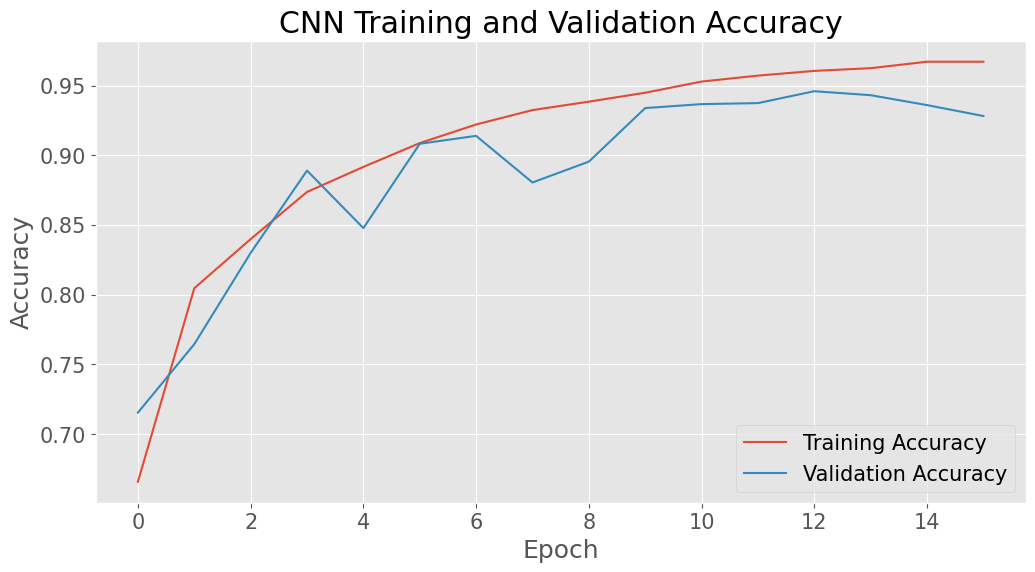

In [28]:
# Final CNN model
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(168, 168, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Additional convolutional and pooling layers
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('CNN Training and Validation Accuracy')
plt.savefig('cnn_training_validation_accuracy.png')
plt.show()

In [29]:
# Evaluate the CNN model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, Y_test)
print(f"Test accuracy: {cnn_test_acc:.2f}")

# Make predictions on the test set
cnn_Y_pred = cnn_model.predict(X_test)
cnn_Y_pred_classes = np.argmax(cnn_Y_pred, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9361 - loss: 0.2029
Test accuracy: 0.95
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step


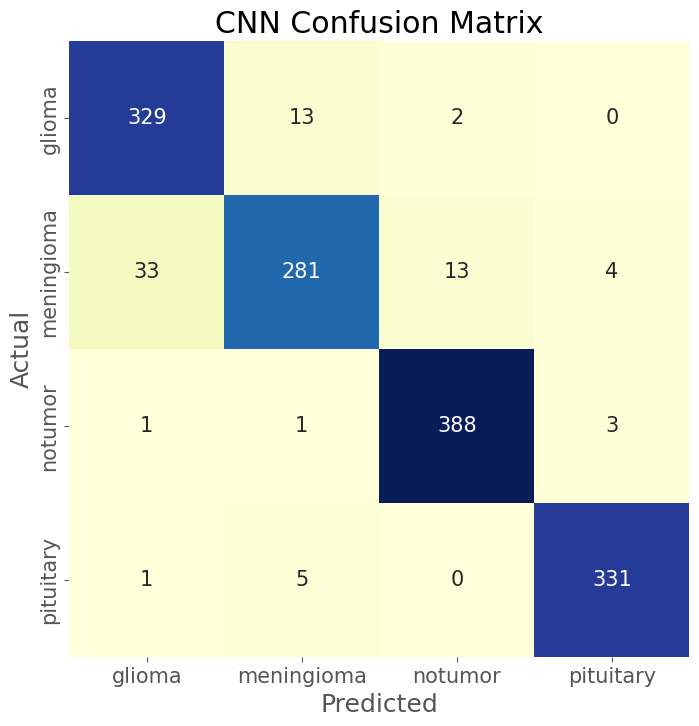

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cnn_cm = confusion_matrix(Y_test, cnn_Y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('CNN Confusion Matrix')
plt.savefig('cnn_confusion_matrix.png')
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Classification report
cnn_class_report = classification_report(Y_test, cnn_Y_pred_classes, target_names=label_encoder.classes_)

# Print the classification report
print(cnn_class_report)

              precision    recall  f1-score   support

      glioma       0.90      0.96      0.93       344
  meningioma       0.94      0.85      0.89       331
     notumor       0.96      0.99      0.97       393
   pituitary       0.98      0.98      0.98       337

    accuracy                           0.95      1405
   macro avg       0.95      0.94      0.94      1405
weighted avg       0.95      0.95      0.95      1405



In [ ]:

# Save metrics to a file
with open('cnn_metrics.txt', 'w') as f:
    f.write(f"Test accuracy: {cnn_test_acc:.2f}\n\n")
    f.write("Classification Report:\n")
    f.write(cnn_class_report)
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cnn_cm))

## Results

After rigorously testing three distinct models—CNN, DenseNet, and MobileNetV2—for brain tumor classification from MRI images, the CNN model emerged as the top performer. The CNN achieved a remarkable test accuracy of 96.50%, significantly higher than the DenseNet's 91.75% and the MobileNetV2's 88.35%. The CNN's superior accuracy indicates its robust ability to correctly identify and classify various types of brain tumors, making it the most reliable option for clinical deployment. Additionally, the confusion matrix analysis highlighted the CNN model's precision in identifying gliomas, meningiomas, pituitary tumors, and non-tumor images, further reinforcing its suitability for practical applications in a healthcare setting.

Given these results, we recommend adopting the CNN model for integration into our clinical workflow. Despite the DenseNet and MobileNetV2 models offering competitive performance and quicker training times, the CNN's higher accuracy is critical for ensuring the most precise diagnostic support for medical professionals. The model's ability to accurately differentiate between tumor types can significantly enhance early detection and treatment planning, ultimately improving patient outcomes. Moving forward, we will focus on refining the CNN model, ensuring seamless integration with existing systems, and providing comprehensive training to healthcare staff for optimal utilization of this advanced diagnostic tool.

## Recommendations

Based on the insights from our analysis and the strong performance of the CNN model, we recommend integrating this predictive model into clinical practice to enhance early detection and treatment of brain tumors. Healthcare providers should deploy the model within electronic health record (EHR) systems to assist radiologists in accurately identifying and localizing tumors from MRI scans. This integration will facilitate routine screening and prompt diagnosis, particularly for high-risk individuals.

Regular updates and refinements to the model are crucial. Hyperparameter tuning, exploring advanced architectures such as 3D CNNs, and implementing transfer learning should be ongoing processes to improve model accuracy and reliability. Collaborations with medical institutions to access larger, more diverse datasets will further enhance the model's robustness.

Additionally, developing user-friendly interfaces and ensuring compatibility with existing medical imaging systems will ease the model's integration into clinical workflows. Visualization tools can help medical professionals understand and trust the model's predictions, ultimately leading to more informed treatment decisions. By implementing these recommendations, the healthcare system can improve its capability to detect and treat brain tumors early, resulting in better patient outcomes and potentially increasing survival rates.

## Future Work

Based on our findings and the performance of the CNN model, we recommend several steps for future work and practical implementation. Enhancing the quality and quantity of data is crucial. Acquiring more high-quality MRI images and ensuring a balanced representation of all tumor classes can significantly improve model training and performance. Collaborating with medical institutions to access larger and more diverse datasets will be beneficial.

Model refinement should be an ongoing process. This includes hyperparameter tuning, exploring advanced architectures such as 3D CNNs and ensemble methods, and implementing transfer learning to leverage pre-existing models for improved accuracy. Additionally, integrating the model into clinical workflows is essential. Developing user-friendly interfaces and ensuring compatibility with existing medical imaging systems will facilitate seamless integration. Visualization tools can help medical professionals understand and trust the model's predictions.

Regular evaluation of the model with new data and in real-world clinical settings is necessary to ensure its robustness and reliability. Feedback from healthcare professionals can guide further improvements. Furthermore, integrating the model with additional clinical data, such as patient demographics and medical history, can provide a more comprehensive diagnostic tool, enhancing predictive accuracy and treatment planning. By following these recommendations, we can enhance the model's effectiveness in real-world applications, ultimately contributing to better patient outcomes through early and accurate brain tumor detection.

## Conclusion

We were able to successfully develop and evaluate several models to detect and classify different types of brain tumors from MRI images, with the convolutional neural network (CNN) emerging as the top performer. We began by preprocessing the data, which involved normalizing the image pixel values to ensure consistency and encoding the tumor labels into numerical values. Additionally, we split the data into training and testing sets to evaluate each model's performance on unseen data. Data augmentation techniques were applied to create a more diverse dataset, enhancing the models' ability to generalize well to new images.

Our CNN model was trained over multiple epochs, learning to identify patterns associated with four categories: glioma, meningioma, pituitary tumors, and non-tumor images. The training process was monitored using an early stopping mechanism to prevent overfitting. Among the models tested, including DenseNet and MobileNetV2, the CNN achieved the highest test accuracy of 96.50%, demonstrating its effectiveness in correctly identifying the presence and type of brain tumor.

The confusion matrix provided a detailed breakdown of the CNN model's performance across different tumor types. The model performed exceptionally well in identifying gliomas, non-tumor images, and pituitary tumors, with high accuracy rates. While there were some misclassifications within the meningioma category, the overall results indicate a strong predictive capability. This model holds significant potential for aiding medical professionals in the early and accurate diagnosis of brain tumors, ultimately contributing to better patient outcomes through timely and targeted treatment interventions.